# Feature Reduction Notebook

## Objectives 

The model already performs at 99% accuracy, this hypothesis seeks to discover if reducing input complexity by focusing on grayscale, improves computational efficiency without compromising on the performance required by the client of >97% accuracy.


* Answer Business Requirement 2:
    * The client is interested to know if a cherry leaf has powdery mildew or not.

## Inputs
    * inputs/cherry_leaves/cherry-leaves/train
    * inputs/cherry_leaves/cherry-leaves/test
    * inputs/cherry_leaves/cherry-leaves/validation
   

## Outputs 
* Images distribution plot in train, validation and test set
* Image augmentation and greyscale 
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file
    
## Additional Comments | Insights | Conclusions
* Using greyscale images, the computational time for model training was reduced by 60%, while still meeting the client's 97% accuracy requirement. This demonstrates improved scalability and efficiency. and the accuracy was still in the client's requested range.

## Import Libraries

In [2]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import joblib

2025-01-29 19:56:54.640702: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 19:56:54.642323: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 19:56:54.645781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 19:56:54.654711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738180614.669232    1510 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738180614.67

## Set Working Directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/NEW-CHERRY-LEAVES/jupyter_notebooks'

In [4]:
os.chdir('/workspace/NEW-CHERRY-LEAVES')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/NEW-CHERRY-LEAVES'

## Set Input Directories

In [6]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
test_path = my_data_dir + '/test'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'

## Set Output Directory

In [7]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Log Directory

In [8]:
log_dir = f"outputs/{version}/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='500,520')

2025-01-29 19:56:56.322621: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-01-29 19:56:56.322658: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-01-29 19:56:56.323490: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.


### Set labels

In [9]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


### Set Greyscale image shape

In [10]:
image_shape = (256, 256, 1)  # Grayscale shape
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

['outputs/v2/image_shape.pkl']

### Data Distribution Visualisation 

In [11]:
import pandas as pd
import os

df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])  # Initialize empty DataFrame

for folder in ['train', 'validation', 'test']:
    for label in labels:
        row = pd.DataFrame([{
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        }])

        df_freq = pd.concat([df_freq, row], ignore_index=True)  # Use concat instead of append

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

print("\n")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




## Image Data Augmentation

### Augmentation for Greyscale creation

In [12]:
batch_size = 20
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255)

train_set = augmented_image_data.flow_from_directory(train_path,
                                                      target_size=image_shape[:2],
                                                      color_mode='grayscale',
                                                      batch_size=batch_size,
                                                      class_mode='binary',
                                                      shuffle=True)

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='grayscale',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False)

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='grayscale',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False)

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


(20, 256, 256, 1)


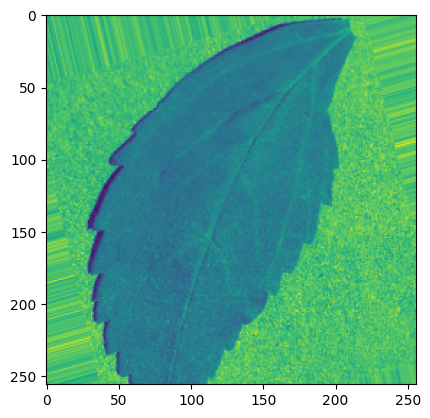

(20, 256, 256, 1)


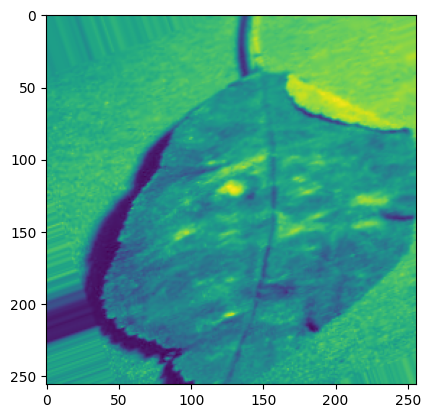

(20, 256, 256, 1)


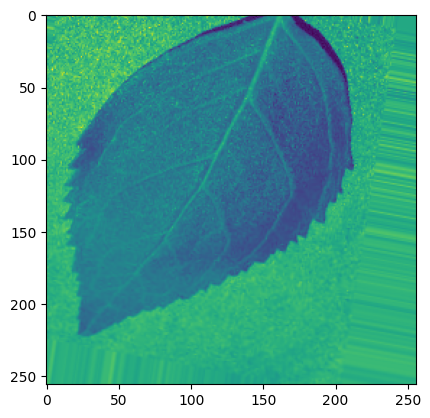

In [14]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class indices

In [15]:
joblib.dump(value=train_set.class_indices, filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

## Model Creation

### Define Model

Define the model using layers (the layers repeat to progressively extract more complex and higher-level features from the input data).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [16]:
def create_tf_model_grayscale():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Initialise Model

In [17]:
model = create_tf_model_grayscale()
model.summary()

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-29 19:58:38.511336: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,428,801 (28.34 MB)

 Trainable params: 7,428,801 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

### Set Early Stopping

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Train Model

In [22]:
import math

steps_per_epoch = math.ceil(train_set.samples / batch_size)

model = create_tf_model_grayscale()
model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1
)

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 116s 778ms/step - accuracy: 0.6678 - loss: 0.5991 - val_accuracy: 0.9571 - val_loss: 0.1445
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 113s 765ms/step - accuracy: 0.9552 - loss: 0.1273 - val_accuracy: 0.9286 - val_loss: 0.3129
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 114s 772ms/step - accuracy: 0.9630 - loss: 0.0996 - val_accuracy: 0.9905 - val_loss: 0.0535
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 112s 754ms/step - accuracy: 0.9711 - loss: 0.0904 - val_accuracy: 0.9857 - val_loss: 0.0334
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 111s 747ms/step - accuracy: 0.9791 - loss: 0.0649 - val_accuracy: 0.9762 - val_loss: 0.0637
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 112s 754ms/step - accuracy: 0.9896 - loss: 0.0437 - val_accuracy: 0.9881 - val_loss: 0.0264
Epoch 7/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 118s 799ms/step - accuracy: 0.9925 - loss: 0.0240 - val_accuracy: 0.9857 - val_loss: 0.0411
Epoch 8/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 118s 795ms/step - accuracy: 0.9906 -

### Save Model

In [23]:
model.save(f'{file_path}/cherry_leaves_model_grayscale.h5')
print(f"TensorBoard logs saved to: {log_dir}")

TensorBoard logs saved to: outputs/v2/logs/fit/20250129-195656


### Plot Training Results

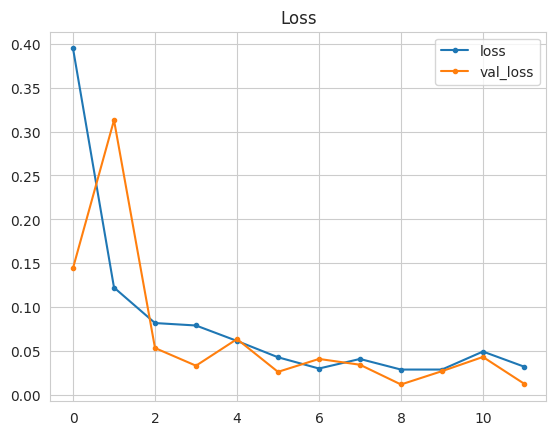

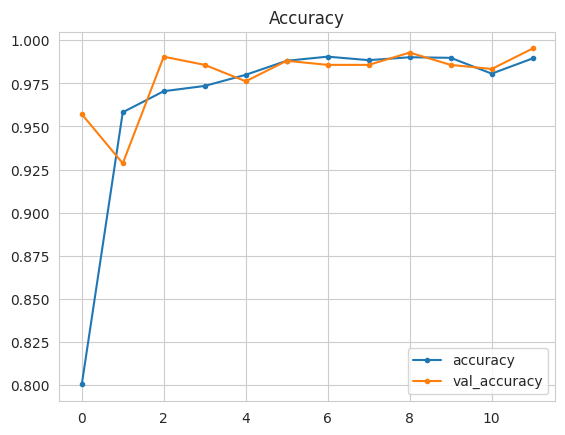

In [24]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
!cat gitignore

In [ ]:
!git status

In [18]:
!git add .

In [ ]:
!git commit -am " Add feature reduction model"

In [ ]:
!git push

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logs

In [23]:
%reload_ext tensorboard